In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import dataframe_image as dfi

from datetime import datetime
from itertools import product
from model import NeuralNet
from simulated_annealing import SA, plot_histories
from scipy.special import softmax
from sklearn.datasets import load_breast_cancer
from sklearn.neural_network import MLPClassifier
from tqdm.notebook import tqdm

np.set_printoptions(precision=4, suppress=True)
np.random.seed(0)

In [2]:
data_attrs = load_breast_cancer()
data_attrs.keys()

data = data_attrs.data
y = data_attrs.target
print(data.shape, y.shape)

data_norm = (data - data.mean(axis=0)) / data.std(axis=0)

(569, 30) (569,)


In [3]:
model = NeuralNet(data=data_norm, y=y, hidden_units=2)    # Criando o modelo de Rede Neural
num_iter = 5                                              # Número de execuções para cada algoritmo

print(f'Quantidade de parâmetros da rede: {model.size(model.sample_weights())}')

Quantidade de parâmetros da rede: 68


In [4]:
# Parâmetros da Rede Neural a partir do SGD
lbfgs_loss, lbfgs_exec_time = np.zeros(num_iter), []

for i in range(num_iter):
    mlp_classifier = MLPClassifier(hidden_layer_sizes=(2,), solver='lbfgs', alpha=0.0, max_iter=2000, max_fun=50000, verbose=False)
    start = datetime.now()
    mlp_classifier.fit(data_norm, y)
    lbfgs_exec_time.append(datetime.now() - start)
    
    p = mlp_classifier.predict_proba(data_norm)
    lbfgs_loss[i] = model.cross_entropy(y, p)
    
lbfgs_loss

array([0.0002, 0.4128, 0.0002, 0.0004, 0.1518])

In [5]:
# Parâmetros da Rede Neural a partir do Simulated Annealing
N_options = [int(1e4), int(1e5)]
T0_options = [0.1, 1., 10.]
K_options =  [6, 8, 12, 16]

# N_options = [int(1e4), int(1e5)]
# T0_options = [0.1, 0.01, 0.001]
# K_options =  [12, 16, 20]

In [ ]:
results = []
start_datetime = str(datetime.now()).split('.')[0].replace(' ', '_').replace(':', '').replace('-', '')

for N, T0, K in product(N_options, T0_options, K_options):
    histories = {}
    eps = 0.01
    for i in tqdm(range(num_iter), desc=f'T0 = {T0}, K = {K}, N = {N}'):
        J_min, x_min, history, exec_time = SA(model, N=N, K=K, T0=T0, eps=eps)
        results.append([N, K, T0, eps, J_min, x_min, exec_time])
        if i == 0: histories['T'] = history[1, :]
        histories[f'iter {i+1}'] = history[0, :]
    hists = pd.DataFrame(histories)
    try: os.mkdir(f".\\results\\Breast-Cancer_{start_datetime}")
    except: pass
    hists.to_pickle(f".\\results\\Breast-Cancer_{start_datetime}\\histories_T0-{T0}_K-{K}_N-{N}.pkl")
        
df = pd.DataFrame(results, columns=['N', 'K', 'T0', 'eps', 'J mínimo', 'x mínimo', 'Tempo de Execução'])
df.to_pickle(f".\\results\\Breast-Cancer_{start_datetime}\\results.pkl")

Backprop, J_mínimo: 0.1131 +/- 0.1609, Tempo de execução médio: 0:00:00.036125

T0: 0.1, K: 6, N: 10000, J_mínimo: 0.8746 +/- 0.1617, Tempo de execução médio: 0:00:28.147068
T0: 0.1, K: 8, N: 10000, J_mínimo: 0.8971 +/- 0.0589, Tempo de execução médio: 0:00:39.145364
T0: 0.1, K: 12, N: 10000, J_mínimo: 0.7537 +/- 0.1573, Tempo de execução médio: 0:00:56.646945
T0: 0.1, K: 16, N: 10000, J_mínimo: 0.6864 +/- 0.2386, Tempo de execução médio: 0:01:17.826529
T0: 1.0, K: 6, N: 10000, J_mínimo: 2.7355 +/- 0.9334, Tempo de execução médio: 0:00:29.202993
T0: 1.0, K: 8, N: 10000, J_mínimo: 2.2517 +/- 0.4135, Tempo de execução médio: 0:00:37.398364
T0: 1.0, K: 12, N: 10000, J_mínimo: 1.9278 +/- 0.1924, Tempo de execução médio: 0:00:57.499001
T0: 1.0, K: 16, N: 10000, J_mínimo: 1.9456 +/- 0.2517, Tempo de execução médio: 0:01:15.863036
T0: 10.0, K: 6, N: 10000, J_mínimo: 7.0098 +/- 2.1077, Tempo de execução médio: 0:00:28.431786
T0: 10.0, K: 8, N: 10000, J_mínimo: 4.2729 +/- 1.2791, Tempo de execu

C:\git\sa-nn\simulated_annealing.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots(figsize=(12, 4))


T0: 10.0, K: 6, N: 100000, J_mínimo: 3.7451 +/- 1.0598, Tempo de execução médio: 0:05:11.873967
T0: 10.0, K: 8, N: 100000, J_mínimo: 4.0786 +/- 0.7547, Tempo de execução médio: 0:06:57.733108
T0: 10.0, K: 12, N: 100000, J_mínimo: 3.4314 +/- 0.4798, Tempo de execução médio: 0:10:26.959538


MemoryError: In draw_path: Out of memory

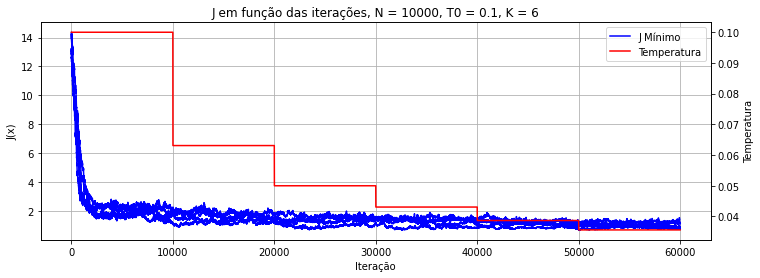

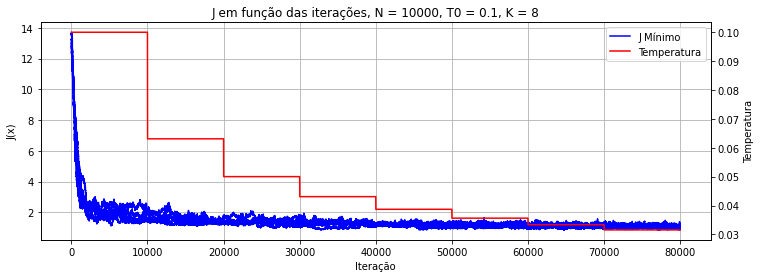

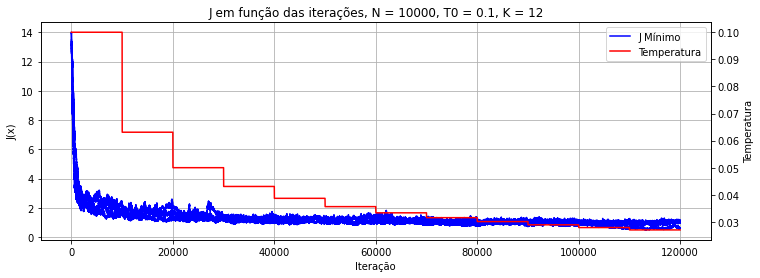

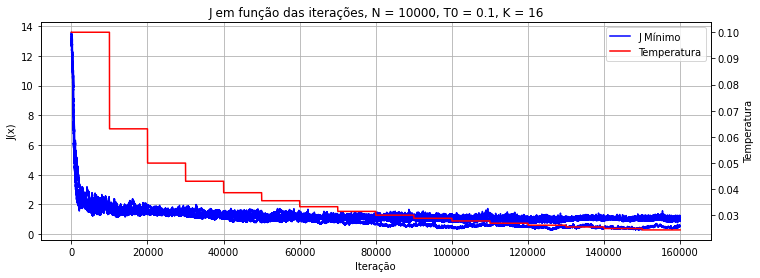

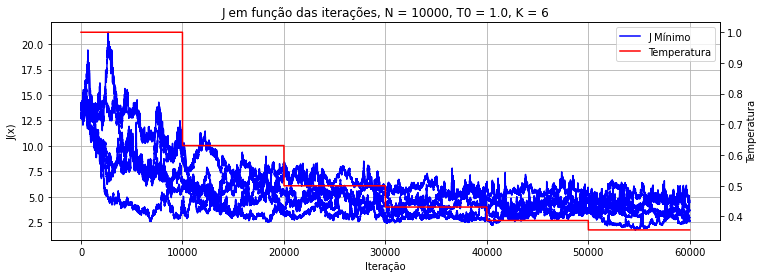

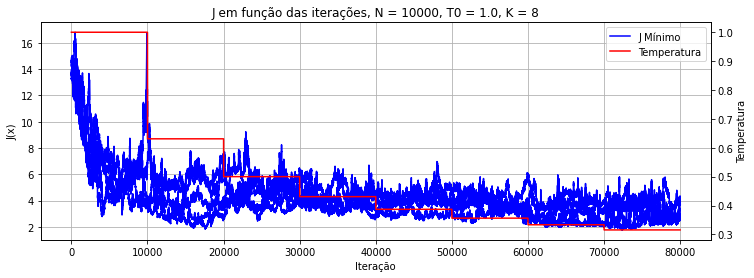

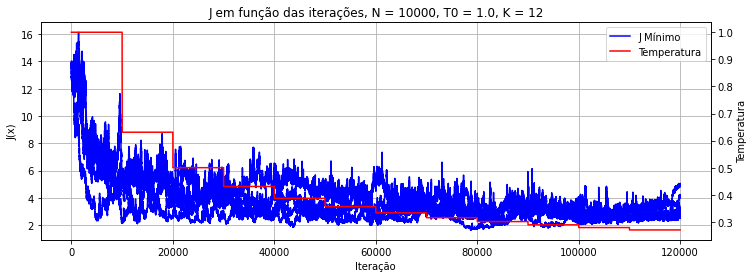

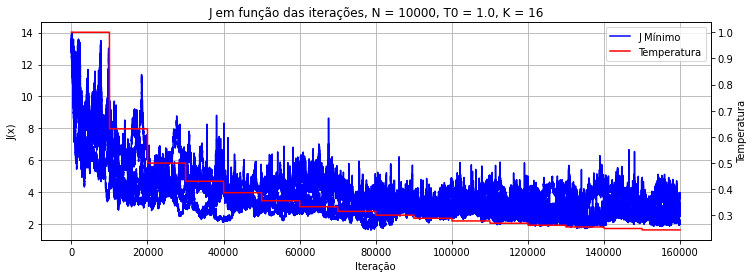

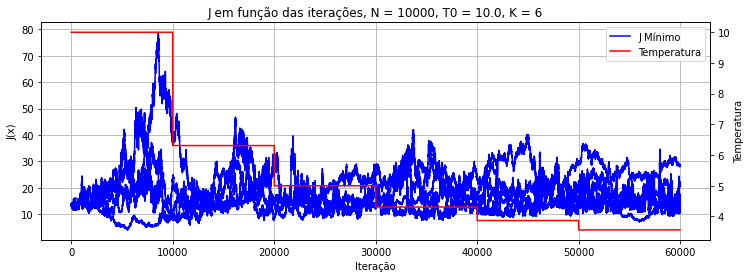

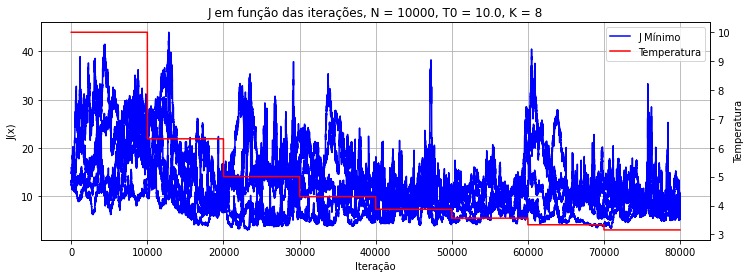

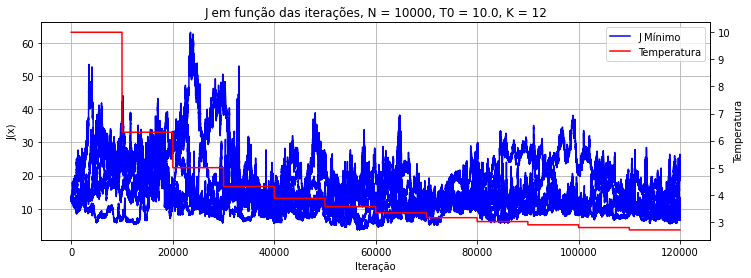

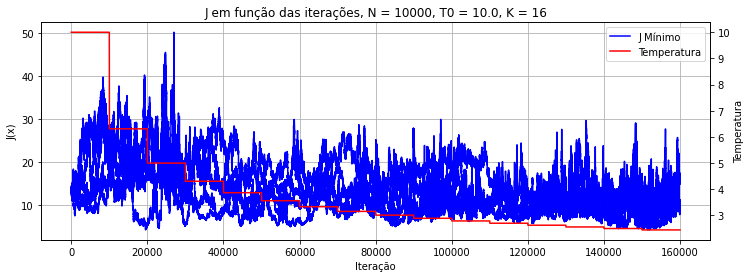

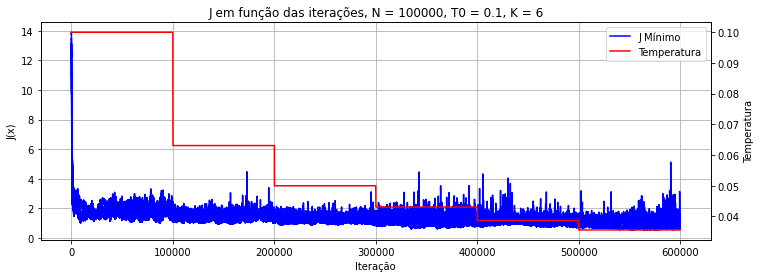

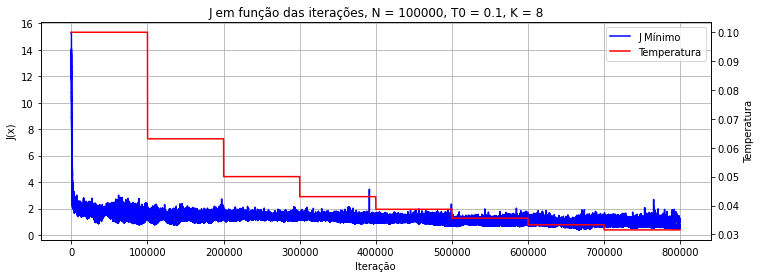

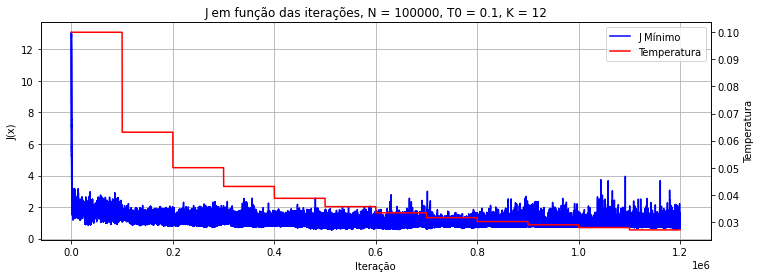

In [ ]:
start_datetime = '20220514_115608'
df = pd.read_pickle(f'.\\results\\Breast-Cancer_{start_datetime}\\results.pkl')

# Backprop
print(f'Backprop, J_mínimo: {np.round(lbfgs_loss.mean(), 4)} +/- {np.round(lbfgs_loss.std(), 4)}, Tempo de execução médio: {np.mean(lbfgs_exec_time)}')
print()

# Simulated Annealing
for N, T0, K in product(N_options, T0_options, K_options):
    # Plot optimization history
    histories = pd.read_pickle(f'.\\results\\Breast-Cancer_{start_datetime}\\histories_T0-{T0}_K-{K}_N-{N}.pkl')
    plot_histories(histories, T0, K, N, savefig=True, dt=start_datetime)

    # Plot results
    filter_ = (df['T0'] == T0) & (df['K'] == K) & (df['N'] == N)
    print(f'T0: {T0}, K: {K}, N: {N}', end=', ')
    J_mean, J_std = df[filter_]['J mínimo'].mean(), df[filter_]['J mínimo'].std()
    t_mean = df[filter_]['Tempo de Execução'].mean().to_pytimedelta()

    print(f"J_mínimo: {np.round(J_mean, 4)} +/- {np.round(J_std, 4)}", end=', ')
    print(f"Tempo de execução médio: {t_mean}")

In [ ]:
mean_results = df.groupby(['N', 'K', 'T0', 'eps'], as_index=False)[['J mínimo', 'Tempo de Execução']].mean(numeric_only=False).sort_values(by='J mínimo', ignore_index=True)

# dfi.export(df, 'dataframe.png')
mean_results

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))

data, labels = [], []
columns = ['SA', 'K', 'T0', 'N']
params = []

for idx, row in mean_results.iloc[:5, :].iterrows():
    N, K, T0 = row.N, row.K, row.T0
    data.append(df[(df['N'] == N) & (df['K'] == K) & (df['T0'] == T0)]['J mínimo'].values)
    labels.append(f'SA {idx+1}')
    params.append([idx+1, K, T0, N])

ax.boxplot([lbfgs_loss.tolist()] + data, labels=['Backprop'] + labels)
ax.set_ylabel('J mínimo')
ax.set_xlabel('Algoritmo')
plt.show()

pd.DataFrame(params, columns=columns).set_index('SA')

In [ ]:
bests = []
for N, T0, K in product(N_options, T0_options, K_options):
    idx = df[(df['N'] == N) & (df['T0'] == T0) & (df['K'] == K)]['J mínimo'].idxmin()
    bests.append(df.iloc[idx, :].tolist())
bests = pd.DataFrame(bests, columns=df.columns).sort_values(by='J mínimo', ignore_index=True)
bests

In [ ]:
data_attrs.keys()